In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
from feature_maps import MediumFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer
from sklearn.svm import SVC
from shot_based_kernel import ShotBasedQuantumKernel

In [69]:
margin = -0.1
Ms = 2**np.arange(6,12)
N = 1000
Cs = [10,1000]
tol = 1e-4

sep = 'separable' if margin > 0 else 'overlap'

In [70]:
y = np.array(pd.read_csv(f'data/2-qubits/{margin}_y_2048.csv')).reshape(-1)
X = np.array(pd.read_csv(f'data/2-qubits/{margin}_X_2048.csv'))

def load_data(M, seed = 42):
        assert (M <= 2048) & (M % 2 == 0)
        np.random.seed(seed)
        indices1 = np.random.randint(0,np.sum(y == 1),M//2)
        indices2 = np.random.randint(0,np.sum(y == -1),M//2)

        X1 = X[y == 1][indices1]
        y1 = y[y == 1][indices1]
        X2 = X[y == -1][indices2]
        y2 = y[y == -1][indices1]

        X12 = np.vstack([X1,X2])
        y12 = np.append(y1,y2)

        shuffle = np.random.choice(M, M, replace=False)
        return X12[shuffle], y12[shuffle]

In [71]:
# Feature map for the experiment
feature_map = MediumFeatureMap(2,4)

# Kernel
adhoc_backend = QuantumInstance(Aer.get_backend('statevector_simulator'))
adhoc_kernel = QuantumKernel(feature_map=feature_map.get_reduced_params_circuit(), quantum_instance=adhoc_backend)

check E ~ M^(1/2)

In [72]:
R = 1024
E = []

Ms = 2**np.arange(4,10)
for M in tqdm(Ms):
    X_,y_ = load_data(M)
    K = adhoc_kernel.evaluate(X_)
    s_k = ShotBasedQuantumKernel(K)
    K_R = s_k.approximate_kernel(R)
    
    E.append(np.linalg.norm(K-K_R,ord=2))
    

100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


array([ 0.51430445, -3.74006656])

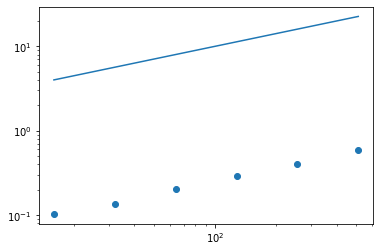

In [73]:
plt.scatter(Ms,E)
plt.yscale('log')
plt.xscale('log')
plt.plot(Ms,np.sqrt(Ms))
p = np.polyfit(np.log(Ms),np.log(E),1)
p

check E ~ R^(-1/2)

In [75]:
M = 16
E = []

Rs = 2**np.arange(4,21)
for R in tqdm(Rs):
    X_,y_ = load_data(M)
    K = adhoc_kernel.evaluate(X_)
    s_k = ShotBasedQuantumKernel(K)
    K_R = s_k.approximate_kernel(R)
    
    E.append(np.linalg.norm(K-K_R,ord=2))
    

100%|██████████| 17/17 [00:08<00:00,  2.03it/s]


[-0.50840732  1.21129321]


Text(0, 0.5, 'Kernel error')

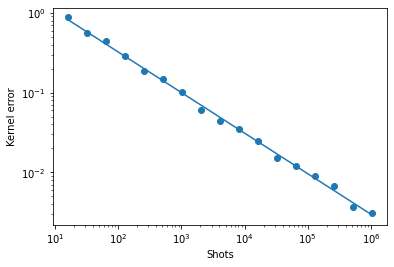

In [76]:
plt.scatter(Rs,E)
plt.yscale('log')
plt.xscale('log')

p = np.polyfit(np.log(Rs),np.log(E),1)
print(p)
plt.plot(Rs,np.exp(p[1])*Rs**p[0])
plt.xlabel('Shots')
plt.ylabel('Kernel error')

In [ ]:
R = 1024
E2= []

Ms = 2**np.arange(3,9)
for M in Ms:
    X_,y_ = load_data(M)
    K = adhoc_kernel.evaluate(X_)
    svc = SVC(kernel='precomputed',C=10)
    svc.fit(K,y_)
    alphas = np.zeros(y_.shape)
    alphas[svc.support_] = svc.dual_coef_

    s_k = ShotBasedQuantumKernel(K)
    K_R = s_k.approximate_kernel(R)
    svc_R = SVC(kernel='precomputed',C=10)
    svc_R.fit(K_R,y_)
    alphas_R = np.zeros(y_.shape)
    alphas_R[svc_R.support_] = svc_R.dual_coef_
    
    E2.append(np.linalg.norm(alphas - alphas_R))
    

array([ 0.92050601, -1.05227211])

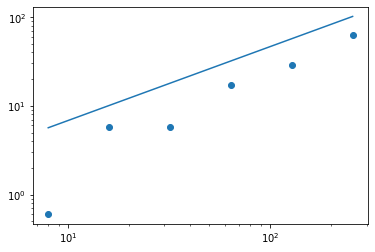

In [ ]:
plt.scatter(Ms,E2)
plt.yscale('log')
plt.xscale('log')
plt.plot(Ms,Ms**(5/6))
p = np.polyfit(np.log(Ms[1:]),np.log(E2[1:]),1)
p

In [ ]:
R = 1024
E3 = []

Ms = 2**np.arange(4,11)
for M in Ms:
    X_,y_ = load_data(M)
    K = adhoc_kernel.evaluate(X_)
    svc = SVC(kernel='precomputed',C=10,random_state=42)
    svc.fit(K,y_)
    alphas = np.zeros(y_.shape)
    alphas[svc.support_] = svc.dual_coef_

    E3.append(np.linalg.norm(alphas))
    

array([0.55355737, 1.44447711])

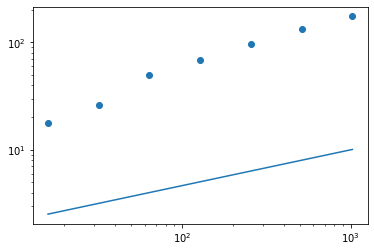

In [ ]:
plt.scatter(Ms,E3)
plt.yscale('log')
plt.xscale('log')
plt.plot(Ms,Ms**(1/3))
p = np.polyfit(np.log(Ms),np.log(E3),1)
p

Continuous Kernel

In [ ]:
def load_data(M, margin, seed = 42):
        
        y = np.array(pd.read_csv(f'data/2-qubits/{margin}_y_2048.csv')).reshape(-1)
        X = np.array(pd.read_csv(f'data/2-qubits/{margin}_X_2048.csv'))

        assert (M <= 2048) & (M % 2 == 0)
        np.random.seed(seed)
        indices1 = np.random.randint(0,np.sum(y == 1),M//2)
        indices2 = np.random.randint(0,np.sum(y == -1),M//2)

        X1 = X[y == 1][indices1]
        y1 = y[y == 1][indices1]
        X2 = X[y == -1][indices2]
        y2 = y[y == -1][indices1]

        X12 = np.vstack([X1,X2])
        y12 = np.append(y1,y2)

        shuffle = np.random.choice(M, M, replace=False)
        return X12[shuffle], y12[shuffle]

In [ ]:
n = 1000
M = 256
#ls = np.linspace(0.9,1,n)
ls = np.geomspace(0.9,1,n)
epsilon = np.zeros((2,n))
delta = np.zeros((2,n))
kernel_error = np.zeros((2,n))

same_supp = np.zeros((2,n))
diff_supp = np.zeros((2,n))

for j, m in enumerate([0.1,-0.1]):
    X_,y_ = load_data(M,m)
    K = adhoc_kernel.evaluate(X_)
    shots_kernel = ShotBasedQuantumKernel(K)
    K_1024 = shots_kernel.approximate_kernel(1024)

    def cont_K(l):
        return l*K + (1 - l)*K_1024

    svc = SVC(kernel='precomputed',C=10,random_state=42)
    svc.fit(K,y_)
    h = svc.decision_function(K)
    alphas = np.zeros(y_.shape)
    alphas[svc.support_] = svc.dual_coef_

    for i, l in enumerate(ls):
        K_l = cont_K(l)
        kernel_error[j,i] = np.linalg.norm(K - K_l,ord=2)

        svc_l = SVC(kernel='precomputed',C=10,random_state=42)
        svc_l.fit(K_l,y_)
        h_l = svc_l.decision_function(K_l)
        alphas_l = np.zeros(y_.shape)
        alphas_l[svc_l.support_] = svc_l.dual_coef_

        same_supp[j,i] = np.sum((alphas_l == 0) == (alphas == 0))
        diff_supp[j,i] = np.sum((alphas_l == 0) != (alphas == 0))

        epsilon[j,i] = np.max(np.abs(h_l - h))
        delta[j,i] = np.linalg.norm(alphas - alphas_l)



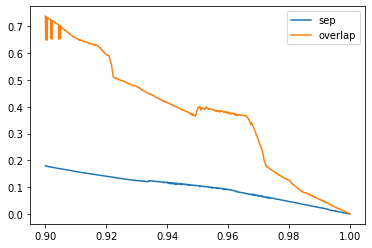

In [ ]:
plt.plot(ls,epsilon[0,:],label='sep')
plt.plot(ls,epsilon[1,:],label='overlap')
plt.legend()

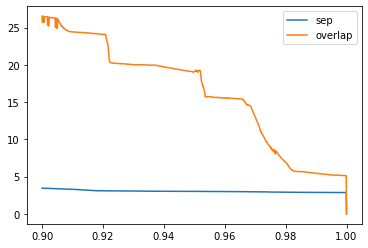

In [ ]:
plt.plot(ls,delta[0,:],label='sep')
plt.plot(ls,delta[1,:],label='overlap')
plt.legend()

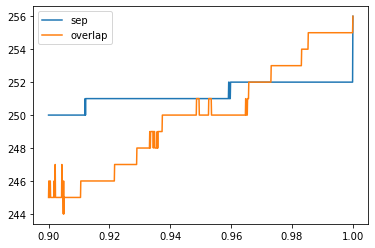

In [ ]:
plt.plot(ls,same_supp[0,:],label='sep')
plt.plot(ls,same_supp[1,:],label='overlap')
plt.legend()

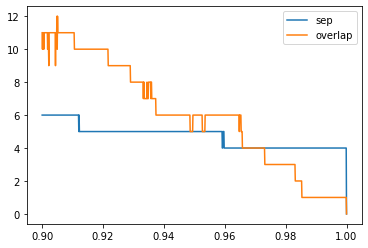

In [ ]:
plt.plot(ls,diff_supp[0,:],label='sep')
plt.plot(ls,diff_supp[1,:],label='overlap')
plt.legend()

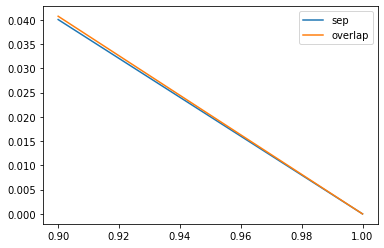

In [ ]:
plt.plot(ls,kernel_error[0,:],label='sep')
plt.plot(ls,kernel_error[1,:],label='overlap')
plt.legend()

smart experiment

array([4.11444457, 4.08624077, 4.15605878, 3.56352658, 3.34572848])

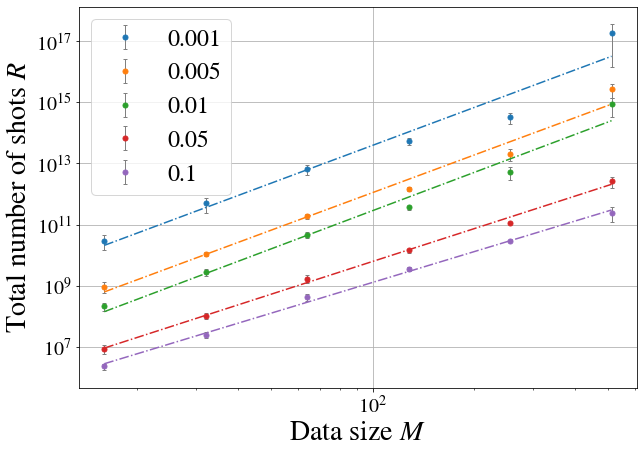

In [ ]:
from dual_smart_experiment import SmartExperiment
s_sep = SmartExperiment(0.1)
s_sep.load()
s_sep.plot()

array([5.4130952 , 3.59613949, 3.46479209, 3.56782169, 3.58774738])

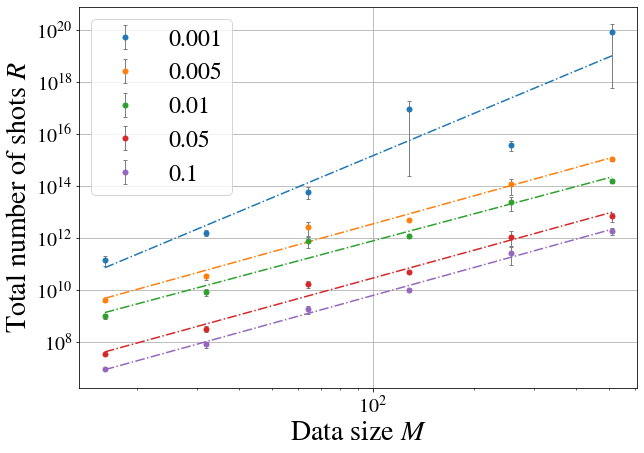

In [ ]:
s_overlap = SmartExperiment(-0.1)
s_overlap.load()
s_overlap.plot()